# MLB Salary Prediction Model - Process

The below script cleans the data and shows the process before training and running the Salary Prediction Model:
- Cleans the data so it can be input into the model
- Discovers and pairs the model down to significant factors
- Observes how different splits between training and testing affect the model


In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [9]:
#first cell for data cleaning

df = pd.read_csv('Honors_Option_Data.csv') #data on arbitration eligible players from 2011-2025

keep_columns = ['Name', 'Shortened_name', 'Team', 'Birthdate', 'Year', 'YOS', 'PlayerOffer', 'TeamOffer', 'PrevSalary_updated', 
                'FinalSalary_Updated', 'WAR_prev', 'WAR_current', 'primary_position']

df_clean = df[keep_columns].copy()
df_clean = df_clean.replace(['Null', 'x'], np.nan)

df_clean = df_clean.iloc[:-594] #dropped final 594 rows because they are very incomplete as they were recently added 

#AI used to learn how to convert birth date's (currently listed as an integer in the format YYYYMMDD to an actual date
#Source: OpenAI. (2025). ChatGPT-5. Accessed from https://chatgpt.com/ on Nov 16, 2025
#Prompt: "How would I convert an integer representing a date as YYYYMMDD to only the year value in order to subtract it from current year"

df_clean['Birth_year'] = df_clean['Birthdate'].astype(str).str[:4].astype(int)
df_clean['Age'] = df_clean['Year'] - df_clean['Birth_year']

#AI used to learn how to convert salary numbers with commas (3,000,000) to integers (3000000)
#Source: OpenAI. (2025). ChatGPT-5. Accessed from https://chatgpt.com/ on Nov 16, 2025
#Prompt: "How would I convert a string value for salaries (3,000,000) to integers ; I have 3 rows with more two values listed one with parentheses
#since they make up a very small portion of the dataset how would I identify and drop those rows?"

df_clean = df_clean[~df_clean['FinalSalary_Updated'].astype(str).str.contains(r'\(')]
df_clean = df_clean[~df_clean['PrevSalary_updated'].astype(str).str.contains(r'\(')]
df_clean = df_clean[~df_clean['PlayerOffer'].astype(str).str.contains(r'\(')]
df_clean = df_clean[~df_clean['TeamOffer'].astype(str).str.contains(r'\(')]

df_clean['FinalSalary_Updated'] = df_clean['FinalSalary_Updated'].astype(str).str.replace(',', '').astype(float)
df_clean['PrevSalary_updated'] = df_clean['PrevSalary_updated'].astype(str).str.replace(',', '').astype(float)
df_clean['PlayerOffer'] = df_clean['PlayerOffer'].astype(str).str.replace(',', '').astype(float)
df_clean['TeamOffer'] = df_clean['TeamOffer'].astype(str).str.replace(',', '').astype(float)

df_clean['YOS'] = df_clean['YOS'].astype(str).str.replace(',', '.').astype(float)

model_FS = df_clean[['FinalSalary_Updated', 'PrevSalary_updated', 'WAR_current', 'WAR_prev', 'Age', 'YOS']].dropna().astype(float)   #drops NA values and converts all values into floats

In [61]:
#checking for key factors in predicting Final Salary
#fits OLS model on all of the original data

x = model_FS[['PrevSalary_updated', 'WAR_current', 'WAR_prev', 'Age', 'YOS']]   #selects the 5 factors going into the model
x = sm.add_constant(x)
y = model_FS['FinalSalary_Updated'] 

Future_Salary_Model = sm.OLS(y, x).fit()   #runs and fits the Future_Salary_Model trained with entire data set and all 5 factors
print(Future_Salary_Model.summary())

                             OLS Regression Results                            
Dep. Variable:     FinalSalary_Updated   R-squared:                       0.813
Model:                             OLS   Adj. R-squared:                  0.812
Method:                  Least Squares   F-statistic:                     1926.
Date:                 Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                         17:27:03   Log-Likelihood:                -34871.
No. Observations:                 2225   AIC:                         6.975e+04
Df Residuals:                     2219   BIC:                         6.979e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.413e

In [11]:
#fits OLS model using only the most significant factors gathered from the previous cell

x = model_FS[['PrevSalary_updated', 'WAR_prev', 'YOS']]   #pairs the model down to the 3 most significant factors
x = sm.add_constant(x)
y = model_FS['FinalSalary_Updated']

Future_Salary_Model = sm.OLS(y, x).fit()   #runs and fits the Future_Salary_Model trained with entire data set and 3 most significant factors
print(Future_Salary_Model.summary())

                             OLS Regression Results                            
Dep. Variable:     FinalSalary_Updated   R-squared:                       0.806
Model:                             OLS   Adj. R-squared:                  0.806
Method:                  Least Squares   F-statistic:                     3074.
Date:                 Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                         13:37:19   Log-Likelihood:                -34911.
No. Observations:                 2225   AIC:                         6.983e+04
Df Residuals:                     2221   BIC:                         6.985e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.822e

In [15]:
#fixes multicollinearity issue by scaling the millions from 1000000 to 1 
#uses of train_test_split to train the model on a portion of the total data

model_FS['PrevSalary_mil'] = model_FS['PrevSalary_updated'] / 1e6   #scaling both salaries from 1000000 to 1
model_FS['FinalSalary_mil'] = model_FS['FinalSalary_Updated'] / 1e6   #scaling both salaries from 1000000 to 1

x = model_FS[['PrevSalary_mil', 'WAR_prev', 'YOS']]
y = model_FS['FinalSalary_mil']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=30)   #splits the original dataset into 80% for training and 20% for testing

x_train_const = sm.add_constant(x_train)
x_test_const = sm.add_constant(x_test)

Millions_Salary_Model = sm.OLS(y_train, x_train_const).fit()   #runs and fits the scaled model trained with the train split data and 3 most significant factors
print(Millions_Salary_Model.summary())

                            OLS Regression Results                            
Dep. Variable:        FinalSalary_mil   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     2085.
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:38:43   Log-Likelihood:                -3434.3
No. Observations:                1780   AIC:                             6877.
Df Residuals:                    1776   BIC:                             6899.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4623      0.184     -2.

# MLB Salary Prediction Model Final

This script predicts next-year MLB player salaries using a linear regression model based on:
- Previous year's salary (in millions)
- Previous season WAR (Wins Above Replacement)
- Years of service (YOS)

It also calculates a salary range using the model's RMSE for reference.


In [58]:
#contains all necessary code from above to fully train and run the Millions_Salary_Model to predict next years salary

model_FS['PrevSalary_mil'] = model_FS['PrevSalary_updated'] / 1e6
model_FS['FinalSalary_mil'] = model_FS['FinalSalary_Updated'] / 1e6

x = model_FS[['PrevSalary_mil', 'WAR_prev', 'YOS']]
y = model_FS['FinalSalary_mil']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state=30)

x_train_const = sm.add_constant(x_train)
x_test_const = sm.add_constant(x_test)

Millions_Salary_Model = sm.OLS(y_train, x_train_const).fit()

predicted = Millions_Salary_Model.predict(x_test_const)
mse = mean_squared_error(y_test, predicted)   #calculate the mean squared error of the test data against the predicted to later calculate salary range

rmse = np.sqrt(mse)   #takes the square root of the mse(mean squared error) to find the error in millions to later calculate salary range

def predict_salary(prev_salary_mil, war_prev, yos, model, rmse):
    """
    Predicts a players next year salary and prints a range based on RMSE.

    Parameters:
    prev_salary_mil : float - Previous Salary in millions
    war_prev : float - Previous season WAR
    yos : float - Current Years of Service in YYDDD format 
    model : Fitted OLS Regression Model
    rmse : float - Model Calculated RMSE for Range Calculation
    """
    x_new = pd.DataFrame({'const':[1], 'Prev_Salary_Mil':[prev_salary_mil], 'WAR_prev':[war_prev], 'YOS':[yos]})

    predicted_new = round(model.predict(x_new)[0], 3)

    lower_bound = round(predicted_new - rmse, 3)
    upper_bound = round(predicted_new + rmse, 3)

    print('Predicted Salary:', predicted_new, '(In Millions $)') 
    print('Salary Range:', lower_bound, '-', upper_bound, '(In Millions $)')

predict_salary(3.5, 2.06, 4.015, Millions_Salary_Model, rmse)

Predicted Salary: 7.263 (In Millions $)
Salary Range: 6.063 - 8.463 (In Millions $)


Text(0.5, 1.0, 'Actual vs Predicted Salary')

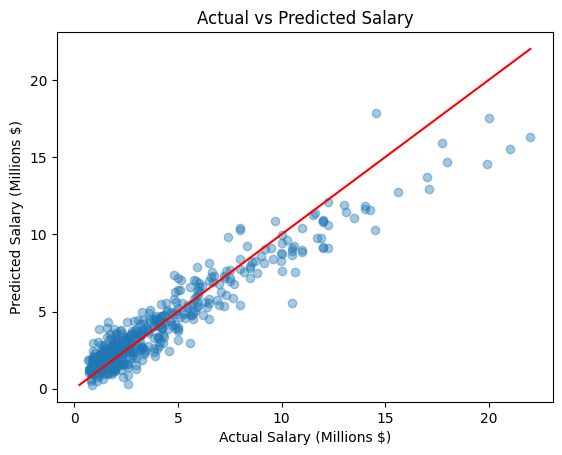

In [52]:
#plots actual vs predicted salary to examine accuracy, close to the line = more accurate

y_actual = y_test
y_pred = Millions_Salary_Model.predict(x_test_const)

plt.scatter(y_actual, y_predicted, alpha=0.4)
min_val = min(y_actual.min(), y_pred.min())   #finds minimum values for 45 degree line
max_val = max(y_actual.max(), y_pred.max())   #finds maximum values for 45 degree line
plt.plot([min_val, max_val], [min_val, max_val], color='red')   #plots 45 degree line for accuracy
plt.xlabel('Actual Salary (Millions $)')
plt.ylabel('Predicted Salary (Millions $)')
plt.title('Actual vs Predicted Salary')